In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import string
import re
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from textblob import TextBlob

In [4]:
def clean_nlp_data(data_path):
    data = pd.read_csv(data_path)
    
    #step 1: Lower-Case conversion
    data['review_description'] = data['review_description'].str.lower()
    
    #step 2: Removal of URL
    data['review_description'] = data['review_description'].str.replace(r'http\S+|www.\S+','',case=False, regex = True)
    
    #Step 3: Punctuation remove
    def remove_punctuation(text):
        return "".join([c  
                        for c in text  
                        if c not in string.punctuation])

    data['review_description'] = data['review_description'].apply(lambda x : remove_punctuation(x))
    
    #step 4: Remove numbers
    data['review_description'] = data['review_description'].str.replace('\d+','', regex = True)
    
    #step 5: Remove Stopwords
    nltk.download('stopwords')
    stop = stopwords.words('english')
    data['review_description'] = data['review_description'].apply(lambda x: ' '.join([abc 
                                                                                      for abc in x.split() 
                                                                                      if abc not in (stop)]))
    #step 6: Remove Common words
    nltk.download('words')
    words = set(nltk.corpus.words.words())
    
    def clean_text_round2(review_description):
        review_description = re.sub('book|customer|hotel|use|ing','', review_description)
        review_description = re.sub(r"\b[a-zA-Z]\b", "", review_description)
        review_description = re.sub(r"\b[a-zA-Z][a-zA-Z]\b", "", review_description)
        review_description = " ".join(w 
                                       for w in nltk.wordpunct_tokenize(review_description)
                                       if w.lower() in words)    
        return review_description
    
    data['review_description'] = data['review_description'].apply(lambda x: clean_text_round2(x))
    
    #step 7: Lemmatization
    nltk.download('wordnet')
    lemmatizer = WordNetLemmatizer()
    word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
    
    def lemmatize_text(review_description):
        return ' '.join([lemmatizer.lemmatize(w,"v") 
                for w in word_tokenizer.tokenize(review_description)])
    
    data['review_description'] = data['review_description'].apply(lambda x: lemmatize_text(x))
    
    #step 8: Strip extra white space
    data['review_description'] = data['review_description'].astype("str").str.rstrip()
    
    #step 9: Removing duplicate rows
    data = data.drop_duplicates('review_description').reset_index(drop = True)
    
    return data

def create_term_document_matrix(data):
    cv = CountVectorizer(stop_words = 'english')
    data_cv = cv.fit_transform(data.review_description)
    data_dtm = pd.DataFrame(data_cv.toarray(), columns = cv.get_feature_names_out())
    tdm = data_dtm.transpose()
    
    tdm['freq'] = tdm.sum(axis = 1)
    tdm.reset_index(inplace = True)
    
    tdm_subset = tdm[["index", "freq"]]
    tdm_subset.rename(columns = {'index': 'Word'}, inplace = True)
    tdm_subset.sort_values(by = 'freq', ascending = False, inplace = True)
    
    return tdm_subset

def generate_word_cloud(data):
    review_description = " ".join(review for review in data['review_description'])
    print(f"There are {len(review_description.split())} words in the combination of all review.")
    
    stopwords = set(STOPWORDS)
    cloud = WordCloud(stopwords=stopwords, # BACK UP
                          background_color="white",
                          collocations=False,
                          max_words=100).generate(review_description)

    #Display the genarate word cloud
    plt.imshow(cloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    
def analyse_sentiment(data):
    data['polarity'] = data['review_description'].apply(lambda x: TextBlob(x).sentiment.polarity)
    
    data['Sentiment'] = np.where(data['polarity'] >= 0, 'Positive', 'Negative')
    
    #Display the pie chart
    data['Sentiment'].value_counts().plot.pie(autopct = "%0.00f%%")
    plt.title('Sentiment Analysis')
    plt.show()
    
    data_content = data[['review_description', 'polarity', 'Sentiment']]
    print(data_content.head())
    return data_content

def export_data(data_content, file_name):
    data_content.to_csv(file_name, index = False)
    print(f'Data exprted to {file_name}')

- It is one of the important steps, whenever we have textual data, we need to apply several pre-processing steps to the data that works with machine learning algorithm.
    - Convert all text to lowercase to ensure consistency in analysis.
    - Eliminate numerical values to focus on textual content.
    - Exclude punctuation marks to avoid interference with word analysis.
    - Remove common words (stopwords) that don't contribute much to the analysis.
    - Eliminate URLs as they don't provide valuable information for sentiment analysis.
    - Reduce words to their base or root form to analyze them as a single entity.
    - Exclude domain-specific or common words that may not be informative.
    - Ensure uniform spacing between words for accurate analysis.

##### MakeMyTrip Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


            Word  freq
1601      refund   733
2042        trip   730
2226       worst   577
1772     service   577
1994      ticket   564
1181        make   537
709   experience   509
606         dont   483
1930     support   461
1998        time   435
1261       money   434
779       flight   401
284         care   364
254          bus   354
2051         try   293
159          bad   266
2030      travel   224
1727         say   221
857         good   220
431      contact   216
There are 36387 words in the combination of all review.


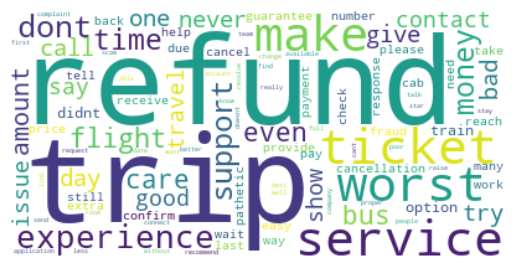

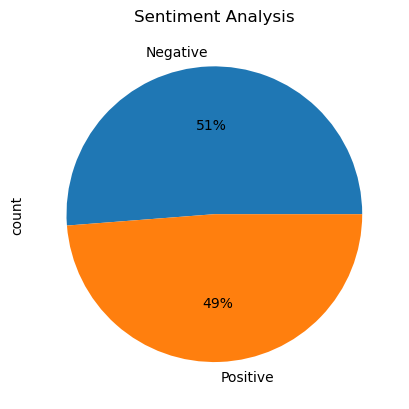

                                  review_description  polarity Sentiment
0  different another try connect service call dis... -0.250000  Negative
1  hope review someone bad mood trip price higher...  0.135714  Positive
2  abysmally poor service would mistake rely make... -0.133333  Negative
3  many lack try senior able time senior citizen ...  0.218750  Positive
4  immediate travel encounter technical issue tra...  0.300000  Positive
Enter the desires file name for export(e.g. sample.csv): 0
Data exprted to 0


In [5]:
csv_path = r"C:\Users\mohds\Downloads\Sem -3\NLP Project\Project\DataSets\Play_store_review_mmt.csv"
data = clean_nlp_data(csv_path)

tdm_result = create_term_document_matrix(data)
print(tdm_result.head(20))

generate_word_cloud(data)

data_content = analyse_sentiment(data)

# export_file_name = input("Enter the desires file name for export(e.g. sample.csv): ")
# export_data(data_content, export_file_name)

##### Insights: 
- Refund-related concerns are significant.
- Service quality and support are key areas of improvement.
- Mixed sentiments indicate a need for consistent user experiences.

##### Goibibo Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


            Word  freq
1565      refund   782
2210       worst   702
1892     support   640
1731     service   632
1958      ticket   578
2026         try   570
757       flight   568
259         care   551
577         dont   531
1231       money   513
1961        time   509
678   experience   492
391      contact   443
1310      option   331
1286      number   294
237          bus   284
1041       issue   280
251       cancel   279
523        didnt   264
1489     provide   231
There are 41716 words in the combination of all review.


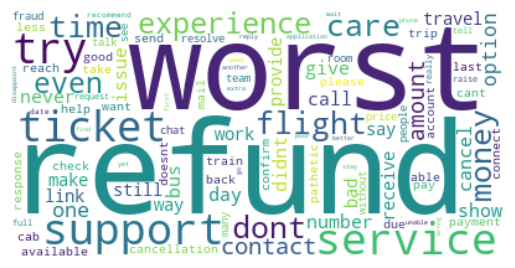

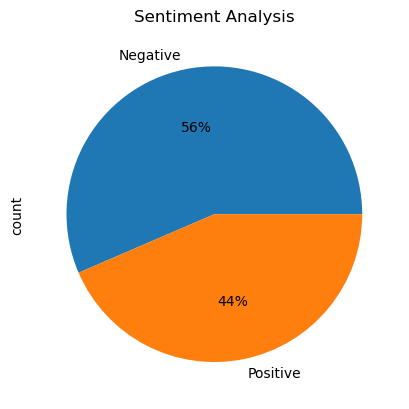

                                  review_description  polarity Sentiment
0  one price staff extra amount check cancel care...  0.012500  Positive
1  bad name railway never different could confirm... -0.173333  Negative
2  worst experience year give bite discount want ... -0.141667  Negative
3  become desperate cannot traditional android cl... -0.045455  Negative
4  check need room stay quite bad lower check old... -0.160000  Negative


In [6]:
csv_path = r"C:\Users\mohds\Downloads\Sem -3\NLP Project\Project\DataSets\Play_store_review_goib.csv"
data = clean_nlp_data(csv_path)

tdm_result = create_term_document_matrix(data)
print(tdm_result.head(20))

generate_word_cloud(data)

data_content = analyse_sentiment(data)

# export_file_name = input("Enter the desires file name for export(e.g. sample.csv): ")
# export_data(data_content, export_file_name)

##### Insights: 
- Refund issues and customer support are prominent.
- Flight-related concerns and negative experiences impact sentiment.
- A focus on improving customer support and addressing specific issues is recommended.

##### Yatra Analysis

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


            Word  freq
1463      refund  1076
2053       worst   818
688       flight   790
519         dont   704
1831      ticket   673
1608     service   665
1136       money   639
1835        time   485
247         care   480
618   experience   479
1761     support   417
1893         try   404
1193      number   387
367      contact   385
227          bus   349
1263     payment   286
435         days   284
1055        mail   279
483        didnt   274
1514    response   257
There are 38934 words in the combination of all review.


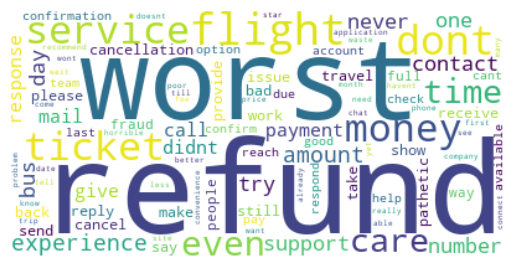

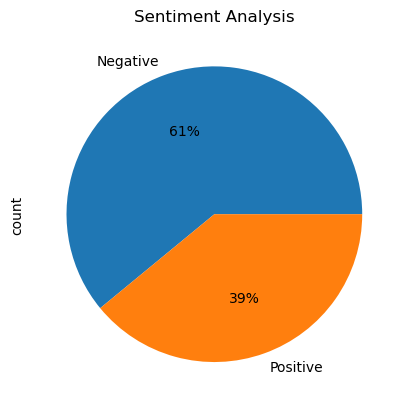

                                  review_description  polarity Sentiment
0  horrible highly recommend alternative possible... -0.122963  Negative
1  worst service ever interface complete mess tim... -0.087500  Negative
2  hopeless mobile application continuously show ...  0.125000  Positive
3  way contact whatsoever call number provide cal...  0.083333  Positive
4  doesnt work try claim several time show error ...  0.060000  Positive


In [7]:
csv_path = r"C:\Users\mohds\Downloads\Sem -3\NLP Project\Project\DataSets\Play_store_review_yatra.csv"
data = clean_nlp_data(csv_path)

tdm_result = create_term_document_matrix(data)
print(tdm_result.head(20))

generate_word_cloud(data)

data_content = analyse_sentiment(data)

# export_file_name = input("Enter the desires file name for export(e.g. sample.csv): ")
# export_data(data_content, export_file_name)

##### Insights: 
- Positive Outlook: Majority of reviews express positive sentiments.
- Common Concerns: Similar to other platforms, refund issues, service and worst experiences are raised.
- Recommendations: Capitalize on positive sentiments in marketing and address specific concerns.

##### Booking.com

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\mohds\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


            Word  freq
642         easy   546
1842     service   414
2103        time   356
877         good   298
885        great   262
1966        stay   254
606         dont   246
1233        make   240
1768        room   230
1541       price   196
1306       money   192
1575    property   190
1434         pay   187
2164         try   182
2018     support   174
1172        like   172
716   experience   166
1665      refund   160
2354        work   155
928         help   149
There are 28926 words in the combination of all review.


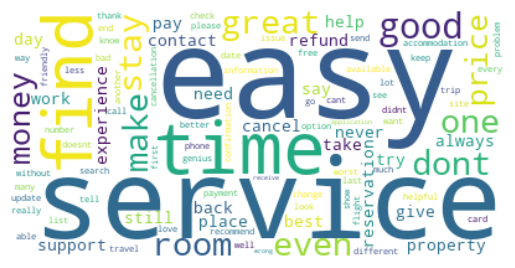

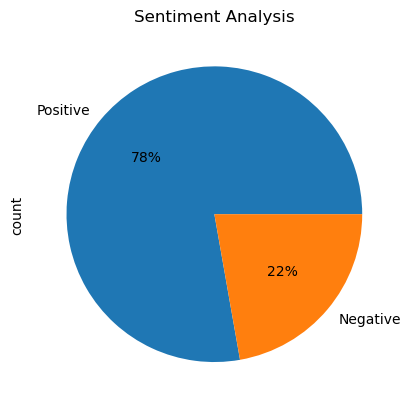

                                  review_description  polarity Sentiment
0  easy navigate brilliant easy communication par...  0.488889  Positive
1  best place stay days last know talk filter rea...  0.083333  Positive
2  without problem issue issue trip good luck sup...  0.143750  Positive
3  pretty decent part suppose would really love s...  0.275505  Positive
4  terrible costumer service spend like days cost... -1.000000  Negative


In [8]:
csv_path = r"C:\Users\mohds\Downloads\Sem -3\NLP Project\Project\DataSets\Play_store_review_booking.csv"
data = clean_nlp_data(csv_path)

tdm_result = create_term_document_matrix(data)
print(tdm_result.head(20))

generate_word_cloud(data)

data_content = analyse_sentiment(data)

# export_file_name = input("Enter the desires file name for export(e.g. sample.csv): ")
# export_data(data_content, export_file_name)

##### Insights: 
- High Positivity: Booking.com has a significantly higher positive sentiment.
- Strengths: Excellent service, positive experiences and good care are highlighted.
- Action Points: Leverage positive feedback in marketing and continue to enhance services.